# Importing Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/__ANN_Colab/hw2/_dataset/

/gdrive/My Drive/__ANN_Colab/hw2/_dataset


# Import Libs

In [ ]:
!pip install tsaug

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [ ]:
dataset['Wonder level']

0        4.33494
1        4.44616
2        4.22372
3        4.22372
4        4.44616
          ...   
68523    6.33690
68524    6.55934
68525    7.00422
68526    6.67056
68527    7.11544
Name: Wonder level, Length: 68528, dtype: float64

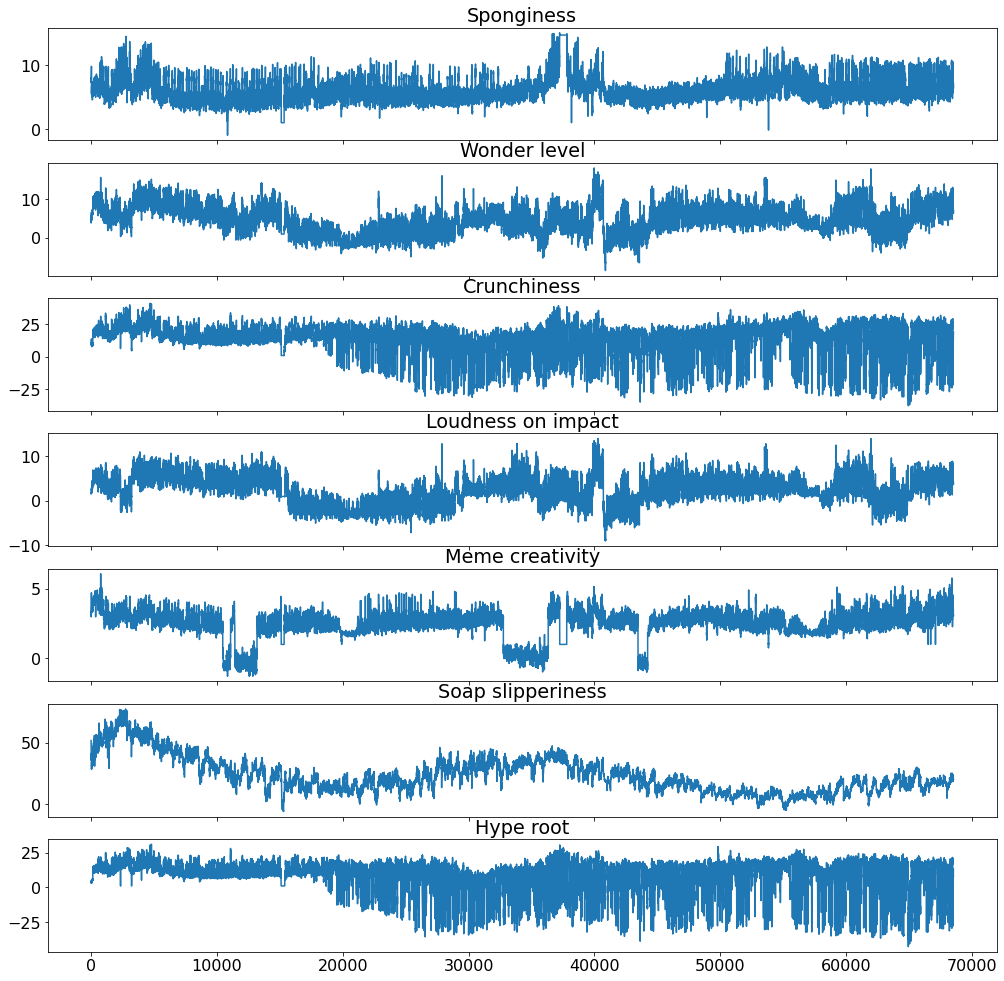

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Here we divide Training and Test

and then we normalize with **MINIMAX NORMALIZATION** 


(65528, 7) (2000, 7) (1000, 7)


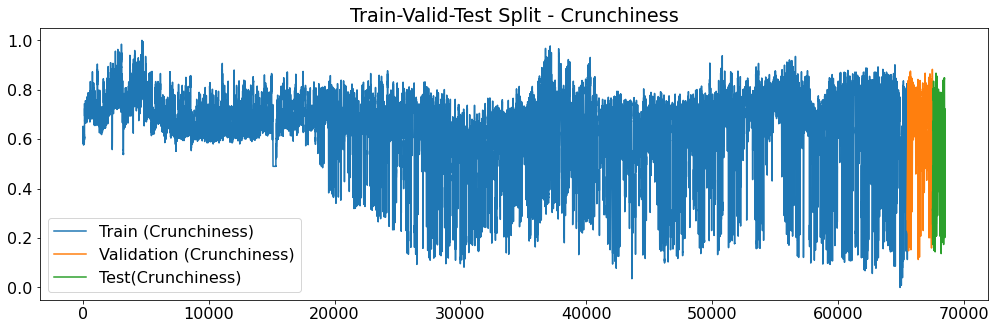

In [ ]:
# Normalize both features and labels
X_min = dataset.min()
X_max = dataset.max()

valid_size = 2000
test_size = 1000

X_train_raw = dataset.iloc[:-(valid_size+test_size)]

# y_train_raw = y.iloc[:-test_size]
X_valid_raw = dataset.iloc[-(valid_size+test_size):-test_size]

X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_valid_raw.shape, X_test_raw.shape)


X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_valid_raw = (X_valid_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_valid_raw.Crunchiness, label='Validation (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test(Crunchiness)')
plt.title('Train-Valid-Test Split - Crunchiness')
plt.legend()
plt.show()

# Splitter

In [ ]:
# target_lables -> which lables I want to predict in the future
# telescope -> how many values I want to predict in the future
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# v8.0.3
Window size to 400 - telescope 1 - new model

performances:

- 2000 : 3.9
- 900 : 3.4

## Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy import interpolate
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

# In the following A POSSIBLE implementation
class CustomSequenceGenerator(tf.keras.utils.Sequence):

  def __init__(self,
               dataset,
               validation_split=0.1,
               which_subset='training',
               batch_size=8,
               window=200,
               stride=1,
               telescope=1):
    
    self.initial_dataset = dataset.copy()
    numpy_dataset = dataset.to_numpy()
    pandas_dataframe = pd.DataFrame(numpy_dataset)
    # print(pandas_dataframe)
    self.X_min = pandas_dataframe.min()
    # print(self.X_min)
    self.X_max = pandas_dataframe.max()
    self.X = pd.DataFrame()
    self.y = pd.DataFrame()
    self.f = [None]*len(dataset.columns)
    
    self.which_subset = which_subset
    self.batch_size = batch_size
    self.window = window
    self.stride = stride
    self.telescope = telescope

    # Save data information
    dataset_len = len(dataset)
    
    indices = np.arange(0, dataset_len)
    # Split in training and validation
    num_valid_samples = int(dataset_len*validation_split)  # 10% for validation and the remaining for training
    train_subset = indices[:-num_valid_samples]
    valid_subset = indices[-num_valid_samples:]

    # Select which subset to load
    if which_subset == 'training':
      self.indices = train_subset
      for col in dataset.columns:
        self.X[col] = train_subset
        self.y[col] = dataset[col][:-num_valid_samples]

    elif which_subset == 'validation':
      self.indices = valid_subset 
      for col in dataset.columns:
        self.X[col] = valid_subset
        self.y[col] = dataset[col][-num_valid_samples:]

    # Create Interpolation
    i = 0
    for column in dataset.columns:
      x_int = self.X[column].to_numpy()
      y_int = self.y[column].to_numpy()
      self.f[i] = interpolate.interp1d(x_int, y_int)
      i+=1


    print("Found {} samples in the {} subset".format(len(self.indices), which_subset))


    # Creating interpolation

    # self.X.to_numpy()
    # self.y.to_numpy()

    # self.interpolation = interpolate.interp1d(self.X, self.y)
    


  def __len__(self):
    # Return the length of the dataset (number of batches)
    # that is given by # number-of-sequences // batch_size
    return self.size // self.batch_size

  def on_epoch_end(self):
    # print("epoch start")
    # On epoch start I need to:
    #   - Sample from the interpolation
    #   - Perform the augmentation on that dataset 
    self.x_epoch = pd.DataFrame()
    self.y_epoch = pd.DataFrame()
    
    ################
    # ITERPOLATION #
    ################
    if self.which_subset == 'training':
      i = 0
      for column in dataset.columns:
        y = self.y[column].to_numpy()
        x = self.X[column].to_numpy()

        x_new = np.array([])
        for _x_ in x:
          if _x_ == x[0]:
            xx = _x_ + random.random() / 2
            x_new = np.append(x_new, xx)
          elif  _x_ == x[len(x)-1]:
            xx = _x_ - random.random() / 2
            x_new = np.append(x_new, xx)
          else:
            xx = _x_ + random.random() / 2
            x_new = np.append(x_new, xx)
        
        # print(x_new)
        ynew = self.f[i](x_new)
        i+=1

        self.x_epoch[column] = x
        self.y_epoch[column] = ynew

    else:
      self.x_epoch = pd.DataFrame(self.X.to_numpy())
      self.y_epoch = pd.DataFrame(self.y.to_numpy())

    if self.which_subset == 'training':
      # pd.concat([self.x_epoch, x_epoch])
      x_epoch = pd.DataFrame()
      y_epoch = pd.DataFrame()
      i = 0
      for column in dataset.columns:
        y = self.y[column].to_numpy()
        x = self.X[column].to_numpy()

        x_new = np.array([])
        for _x_ in x:
          if _x_ == x[0]:
            xx = _x_ + random.random() / 2
            x_new = np.append(x_new, xx)
          elif  _x_ == x[len(x)-1]:
            xx = _x_ - random.random() / 2
            x_new = np.append(x_new, xx)
          else:
            xx = _x_ + random.random() / 2
            x_new = np.append(x_new, xx)
        
        # print(x_new)
        ynew = self.f[i](x_new)
        i+=1

        x_epoch[column] = x
        y_epoch[column] = ynew
      
      # x_epoch = pd.DataFrame(x_epoch.to_numpy())
      # y_epoch = pd.DataFrame(y_epoch.to_numpy())

      self.x_epoch = pd.concat([self.x_epoch, x_epoch])
      self.y_epoch = pd.concat([self.y_epoch, y_epoch])

    # ################
    # # AUGMENTATION #
    # ################

    # self.x_epoch = self.x_epoch.to_numpy()
    # self.y_epoch = self.y_epoch.to_numpy()

    # if self.which_subset == 'training':
    #   my_augmenter = (
    #       # TimeWarp() * 5  @ 0.1 # random time warping 5 times in parallel
    #       # + Crop(size=300)  # random crop subsequences with length 300
    #       Quantize(n_levels=[10, 20, 30]) @ 0.2 # random quantize to 10-, 20-, or 30- level sets
    #       + Drift(max_drift=(0.1, 0.5)) @ 0.1  # with 80% probability, random drift the signal up to 10% - 50%
    #       + Reverse() @ 0.1  # with 50% probability, reverse the sequence
    #   )

    #   X_aug, Y_aug = my_augmenter.augment(self.x_epoch, self.y_epoch)
    #   # print(X_aug.shape)
    #   # print(Y_aug.shape)
    #   # plot(X_aug, Y_aug)

    #   self.x_epoch = pd.DataFrame(X_aug)
    #   self.y_epoch = pd.DataFrame(Y_aug)

      self.x_epoch = self.x_epoch.to_numpy()
      self.y_epoch = self.y_epoch.to_numpy()

    self.y_epoch = (pd.DataFrame(self.y_epoch)-self.X_min)/(self.X_max-self.X_min)

    self.size = len(self.y_epoch)

  def __getitem__(self, index):
    # In this function we generate a batch (of size self.batch_size) of three components
    # - Encoder input (ita)
    # - Decoder input (eng)
    # - Target (eng)
    
    # Get 'self.batch_size' indices
    # current_indices = self.indices[(index*self.batch_size):((index*self.batch_size)+self.batch_size)]

    # Init lists that will contain inputs and target
    inputs = []
    targets = []

    # print(self.x_epoch.shape)
    start = index*self.batch_size
    end = (index*self.batch_size)+self.batch_size
    # print("start: " + str(start))
    # print("end: " + str(end))
    # print(self.indices)
    x_batch = self.x_epoch[start:end]
    # print(x_batch.shape)
    y_batch = self.y_epoch[start:end]

    inputs, targets = build_sequences(pd.DataFrame(y_batch), np.arange(0,7), self.window, self.stride, self.telescope)

    return inputs, targets

## Training phase

In [ ]:
window = 400
stride = 1
telescope = 1
target_labels = dataset.columns

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_valid, y_valid = build_sequences(X_valid_raw, target_labels, window, stride, telescope)
X_test, y_test_ = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test_.shape

((65199, 400, 7),
 (65199, 1, 7),
 (1599, 400, 7),
 (1599, 1, 7),
 (799, 400, 7),
 (799, 1, 7))

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

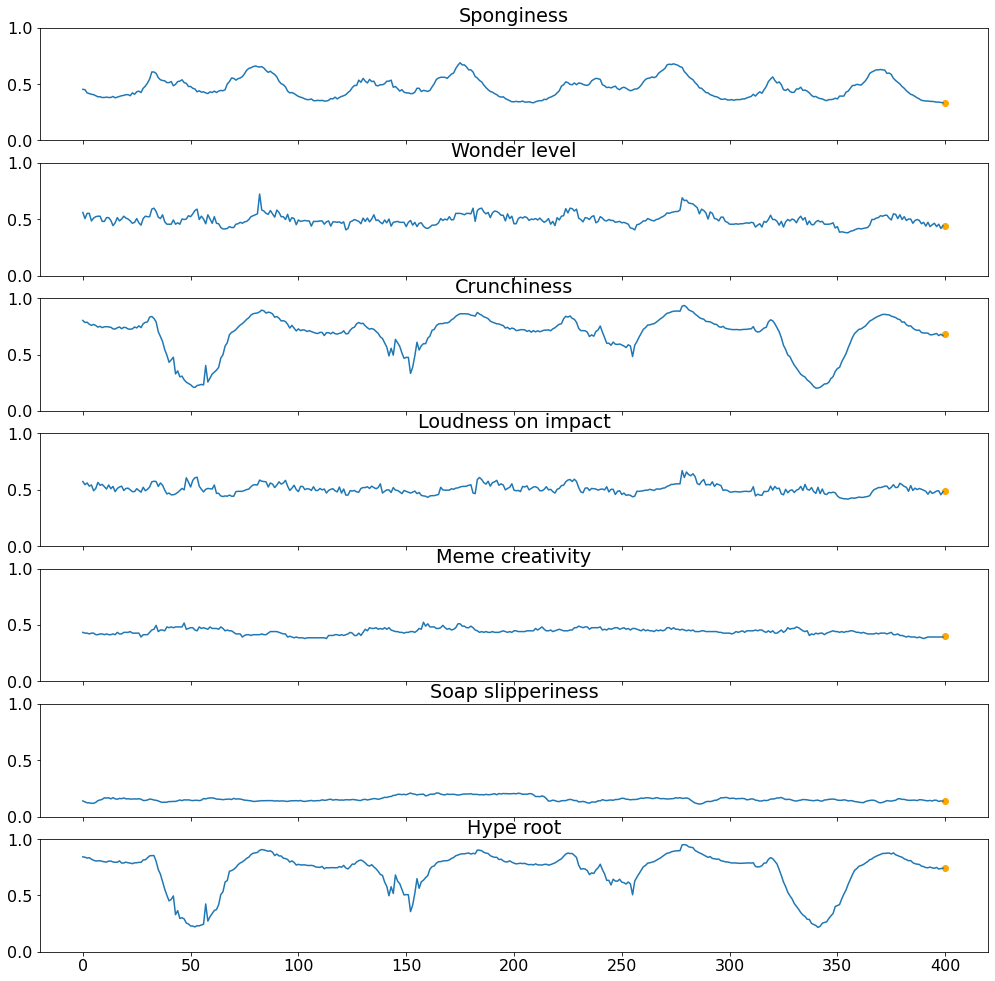

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

Training phase

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [ ]:
def build_model_2(window, stride, telescope, features):
  # ENCODER
  input = tf.keras.Input(shape=(window, features), name='encoder_input_')
  
  ############
  encoder = tfkl.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True, return_state=True, name='encoder_lstm_1_2'))(input)
  encoder_output = encoder[0]
  encoder_state_1_1 = encoder[1:]
  encoder = tfkl.Bidirectional(tf.keras.layers.LSTM(units=128, return_state=True, name='encoder_lstm_1_2'))(encoder_output)
  encoder_output = encoder[0]
  encoder_state_1_2 = encoder[1:]

  

  dense = tfkl.Dropout(0.3)(encoder_output)
  dense = tfkl.Dense(128, activation='relu')(dense)
  encoder_out = tfkl.Dense(telescope*features)(dense)
  encoder_out_1 = tfkl.Reshape((telescope,features))(encoder_out)
  ############

  ############
  encoder = tfkl.Bidirectional(tf.keras.layers.LSTM(units=128, return_state=True, name='encoder_lstm_2'))(input)
  encoder_output = encoder[0]
  encoder_state_2 = encoder[1:]

  dense = tfkl.Dropout(0.3)(encoder_output)
  encoder_out = tfkl.Dense(telescope*features)(dense)
  encoder_out_2 = tfkl.Reshape((telescope,features))(encoder_out)
  ############

  ############
  encoder = tfkl.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True, return_state=True, name='encoder_lstm_3_1'))(input)
  encoder_output = encoder[0]
  encoder_state_3_1 = encoder[1:]
  encoder = tfkl.Bidirectional(tf.keras.layers.LSTM(units=256, return_state=True, name='encoder_lstm_3_2'))(input)
  encoder_output = encoder[0]
  encoder_state_3_2 = encoder[1:]

  dense = tfkl.Dropout(0.3)(encoder_output)
  dense = tfkl.Dense(128, activation='relu')(dense)
  encoder_out = tfkl.Dense(telescope*features)(dense)
  encoder_out_3 = tfkl.Reshape((telescope,features))(encoder_out)
  ############

  
  out_encoder = tfkl.Average()([encoder_out_1,  encoder_out_2, encoder_out_3])

  # # DECODER
  decoder_lstm = tfkl.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True, name='decoder_lstm'))(out_encoder, initial_state=encoder_state_1_2)
  decoder_lstm = tfkl.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True, name='decoder_lstm'))(decoder_lstm, initial_state=encoder_state_2)
  decoder_lstm = tfkl.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True, name='decoder_lstm'))(decoder_lstm, initial_state=encoder_state_3_2)
  
  out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))(decoder_lstm)

  # dense = tf.keras.layers.Dense(telescope*features, activation='relu', name='decoder_out')(decoder_lstm)
  # decoder_out = tfkl.Reshape((telescope,features))(dense)

  model = tf.keras.Model(input, out)

  model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'], run_eagerly=True)
  
  return model

In [ ]:
model = build_model_2(window, stride, telescope, 7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_ (InputLayer)    [(None, 400, 7)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 400, 128),   36864       ['encoder_input_[0][0]']         
                                 (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [ ]:
generator_train = CustomSequenceGenerator(dataset.iloc[:-(valid_size+test_size)], which_subset='training', batch_size=batch_size, window=window, stride=stride, telescope=telescope)
generator_train.on_epoch_end()
generator_validation = CustomSequenceGenerator(dataset.iloc[:-(valid_size+test_size)], which_subset='validation', batch_size=batch_size, window=window, stride=stride, telescope=telescope)
generator_validation.on_epoch_end()

Found 61676 samples in the training subset
Found 6852 samples in the validation subset


In [ ]:
generator_train.size

123352

In [ ]:
generator_train.__len__()

120

In [ ]:
a, b = generator_train.__getitem__(0)

In [ ]:
a.shape

(799, 400, 7)

In [ ]:
# Train the model
history = model.fit(
    generator_train,
    validation_data=generator_validation,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
120/120 [==============================] - 89s 735ms/step - loss: 0.0116 - mae: 0.0714 - val_loss: 0.0041 - val_mae: 0.0456 - lr: 0.0010
Epoch 2/200
120/120 [==============================] - 88s 734ms/step - loss: 0.0022 - mae: 0.0345 - val_loss: 0.0024 - val_mae: 0.0336 - lr: 0.0010
Epoch 3/200
120/120 [==============================] - 88s 736ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0027 - val_mae: 0.0372 - lr: 0.0010
Epoch 4/200
120/120 [==============================] - 88s 734ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 0.0020 - val_mae: 0.0293 - lr: 0.0010
Epoch 5/200
120/120 [==============================] - 88s 736ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0019 - val_mae: 0.0293 - lr: 0.0010
Epoch 6/200
120/120 [==============================] - 88s 734ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 0.0024 - val_mae: 0.0357 - lr: 0.0010
Epoch 7/200
120/120 [==============================] - 88s 737ms/step - loss: 9.7457e-04 - mae: 0.0218 - v

In [ ]:
model.save("models/v8/hw2_model_v8.0.3.h5")

## Testing (Validation data)

In [ ]:
X_valid_to_predict = dataset.iloc[-(valid_size+test_size):-test_size]
print(X_valid_to_predict.shape)

XXX = dataset.iloc[:-(valid_size+test_size)]
print(XXX.shape)

(2000, 7)
(65528, 7)


In [ ]:
X_valid_to_predict = tf.convert_to_tensor(X_valid_to_predict)  

XXX_to_ = tf.convert_to_tensor(XXX)  

In [ ]:
import math

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'models/v8/hw2_model_v8.0.3.h5'))

    def predict(self, X, window=200, stride=10, telescope=100, to_predict=864):
        # Normalize both features and labels
        col_max = np.max(X, axis=0)
        col_min = np.min(X, axis=0)
        X_norm = np.divide(X - col_min, col_max - col_min)
        # print(X.shape)
        # print(type(X))
        # X_norm = (X-X_min)/(X_max-X_min)
        # print(X_norm.shape)
        X = X_norm[-window:]
        # print(X.shape)
        X = np.expand_dims(X, axis=0)
        # print(X.shape)

        out = np.array([])
        
        for i in range(int(math.ceil(to_predict / stride))):
          pred = self.model.predict(X)
          pred = np.array(pred)

          X = np.concatenate((X[0], pred[0][:stride]), axis=0)
          X = np.expand_dims(X, axis=0)
          if i != 0:
            out = np.concatenate((out, pred[0][:stride]), axis=0)
          else:
            out = pred[0][:stride]
            

          X = X[0][-window:]
          X = np.expand_dims(X, axis=0)
          # print(X.shape)
          # print(out.shape)

        #   Insert your postprocessing here
        out = out[:to_predict]
        # print(out.shape)
        # out = pd.DataFrame(out, columns=orig_X.)
        # print(out)
        # print(type(out))
        # print(out.shape)
        # print(X_min)
        # print(X_max)
        # out = (out-X_min)/(X_max-X_min)
        out = np.multiply(out, col_max - col_min)
        out = out + col_min
        # print(out.shape)
        # out = out + X_min
        # print(out.shape)
        # out = out.to_numpy()
        # print(out.shape)
        out = tf.convert_to_tensor(out)
        return out

In [ ]:
mod = model('/gdrive/My Drive/__ANN_Colab/hw2/_dataset/')

In [ ]:
pred = mod.predict(XXX_to_, window=window, stride=stride, telescope=telescope, to_predict=2000)

In [ ]:
print(pred.shape)

(2000, 7)


In [ ]:
y_valid_raw = dataset.iloc[-(valid_size+test_size):-(test_size)]
y = tf.convert_to_tensor(y_valid_raw)  
print(y.shape)

(2000, 7)


In [ ]:
pred_new = pred[0:900]
y_new = y[0:900]
print(pred_new.shape)
print(y_new.shape)

(900, 7)
(900, 7)


In [ ]:
mean_squared_error = tfk.metrics.mse(y_new.numpy().flatten(),pred_new.numpy().flatten())
mean_absolute_error = tfk.metrics.mae(y_new.numpy().flatten(),pred_new.numpy().flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=37.8357427122218>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.966378638185122>)

In [ ]:
mean_squared_error = tfk.metrics.mse(y.numpy().flatten(),pred.numpy().flatten())
mean_absolute_error = tfk.metrics.mae(y.numpy().flatten(),pred.numpy().flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=31.159508168787912>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.4316769062381605>)

In [ ]:
# print(y[:,0])

In [ ]:
def inspect_multivariate_prediction_test_scatter(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        # axs[i].plot(np.arange(len(X[:,i])), X[:,i])
        axs[i].scatter(np.arange(len(X[:,i])), y[:,i], color='orange')
        axs[i].scatter(np.arange(len(X[:,i])), pred[:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

def inspect_multivariate_prediction_test_plot(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        # axs[i].plot(np.arange(len(X[:,i])), X[:,i])
        axs[i].plot(np.arange(len(X[:,i])), y[:,i], color='orange')
        axs[i].plot(np.arange(len(X[:,i])), pred[:,i], color='green')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

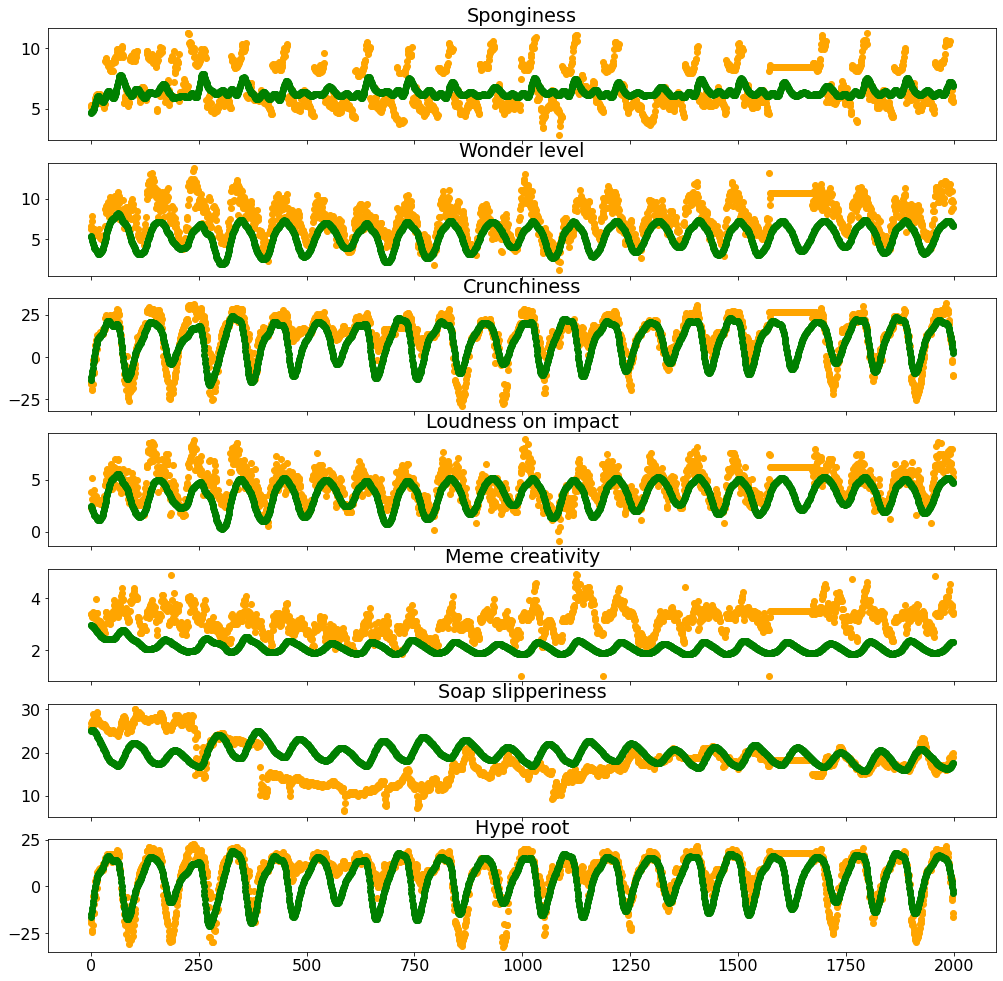

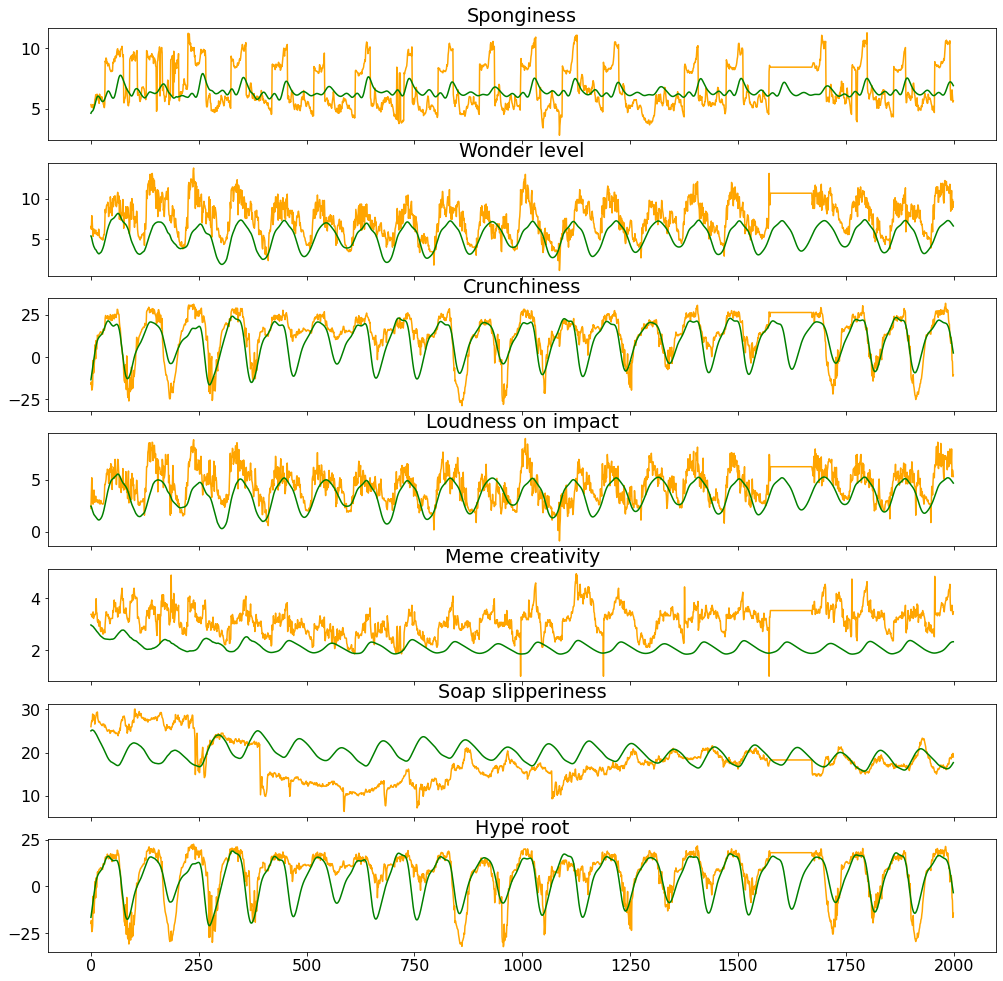

In [ ]:
inspect_multivariate_prediction_test_scatter(y, y, pred, target_labels, 2000, 0)
inspect_multivariate_prediction_test_plot(y, y, pred, target_labels, 2000, 0)